# Exercise sheet 6 - Generalized Linear Models with Scikit Learn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.stats import rankdata
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from mpl_toolkits.mplot3d import Axes3D
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

###### Reference: https://en.wikipedia.org/wiki/Pearson_correlation_coefficient
### Function Name: pearson_coefficient: 
##### Parameter: Data for correlation
   The Pearson correlation coefficient (PCC) is a measure of the linear correlation between two variables X and Y. PCC or 'r' has a value between +1 and −1

\begin{align}
r = \frac{\sum _{i=1}^{n}(x_{i}-{\bar {x}})(y_{i}-{\bar {y}})}{\sqrt {{\sum _{i=1}^{n}}(x_{i}-{\bar {x}})^2}\sqrt {{\sum _{i=1}^{n}}(y_{i}-{\bar {y}})^2}} \\
\end{align}

###### Reference: https://statistics.laerd.com/statistical-guides/pearson-correlation-coefficient-statistical-guide.php
    
    Assumptions:
        1.The variables must be either interval or ratio measurements.
        2.The variables must be approximately normally distributed.
        3.There is a linear relationship between the two variables
        4.Outliers are either kept to a minimum or are removed entirely.
        5.There is homoscedasticity of the data.


In [3]:
def pearson_coefficient(x,y):
    x = x - np.mean(x)
    y = y - np.mean(y)
    return (np.sum(x*y)/np.sqrt(np.sum(x*x)*np.sum(y*y)))
    

### Function Name: read_data
##### Parameter: Filename,column names
This function reads the data and returns the data with its headers

In [4]:
def read_data(filename,columns,delimit):
    if columns == None:
        data = pd.read_csv(filename, sep='\s+', delimiter = delimit)
        return data
    data = pd.read_csv(filename, sep='\s+',header = None)
    data.columns = columns
    return data

### Function Name: check_na_null
##### Parameter: dataframe, column names

This function checks the presence of null or NA values within the dataset

In [5]:
def check_na_null(data):
    data.isnull().values.any()
    data.dropna(inplace = True)
    data = pd.get_dummies(data=data)
    return data

###### Reference: http://mathworld.wolfram.com/FrobeniusNorm.html
### Function name: normalise_data
###### Parameters: data to be normalised

numpy.linalg.norm function returns the normalisation of a matrix. By default, it returns Forbenius Norm of a matrix

\begin{align}
{A}_{norm} = \sqrt{\sum_{i=1}^m\sum_{j=1}^n |A_{i,j}|^2} \\
\end{align}

In [6]:
def normalise_data(data):
    norm_data = data.copy()
    for columns in norm_data:
        norm_data[columns] = norm_data[columns]/np.linalg.norm(norm_data[columns])
    return norm_data

def denormalise_data(data,norm_data):
    denorm_data = norm_data.copy()
    denorm = np.linalg.norm(data[str(data.columns[-1])])
    for i in range (0,len(norm_data)):
        for j in range (0,len(norm_data[i])):
            denorm_data[i][j] = norm_data[i][j] * denorm
    return denorm_data

In [7]:
def text_to_number(data,column):
    for i in column:
        data[i] = pd.Categorical(data[i])
        data[i] = data[i].cat.codes
    return data

In [8]:
def RMSE(y_data,y_pred):
    return np.sqrt(np.sum(pow((y_data - y_pred),2))/len(y_pred))

### Function Name: create_Test_Train_data
### Parameter: Data of input variables and target
This function splits the input variables and target data to Train and Test data with 80% and 20% of the data respectively

In [9]:
def create_Test_Train_data(X_data,Y_data):
    Y_train = Y_data[:math.ceil(0.8*len(Y_data))]
    Y_test = Y_data[math.ceil(0.8*len(Y_data)):]
    X_train = X_data[:math.ceil(0.8*len(X_data))]
    X_test = X_data[math.ceil(0.8*len(X_data)):]
    return Y_train,Y_test,X_train,X_test

## Wine dataset

In [10]:
filename = "./Dataset/winequality-red.csv"
columns = None
redwinedata = read_data(filename,columns,';')
redwinedata.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [11]:
redwinedata_correlation = []
Correlation = pd.DataFrame(index=np.arange(0, 1), columns=redwinedata.columns )
for column in redwinedata:
    if column != "quality":
        Correlation[column] = (str(round(pearson_coefficient
                                                 (np.array(redwinedata[column]),np.array(redwinedata["quality"])),4)))
Correlation

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0.1241,-0.3906,0.2264,0.0137,-0.1289,-0.0507,-0.1851,-0.1749,-0.0577,0.2514,0.4762,NaN


In [12]:
Required_redwinedata = redwinedata.drop(columns = ['residual sugar','free sulfur dioxide','pH','fixed acidity','chlorides','total sulfur dioxide'])
                                #,'Avg_Fare1','Avg_Fare2','Mrkt_Share1','Mrkt_Share2'])
Required_redwinedata.head()

,volatile acidity,citric acid,density,sulphates,alcohol,quality
0,0.70,0.00,0.9978,0.56,9.4,5
1,0.88,0.00,0.9968,0.68,9.8,5
2,0.76,0.04,0.9970,0.65,9.8,5
3,0.28,0.56,0.9980,0.58,9.8,6
4,0.70,0.00,0.9978,0.56,9.4,5


In [13]:
Required_redwinedata = normalise_data(Required_redwinedata)
Required_redwinedata.head()

,volatile acidity,citric acid,density,sulphates,alcohol,quality
0,0.031409,0.000000,0.025034,0.020606,0.022436,0.021962
1,0.039485,0.000000,0.025009,0.025022,0.023391,0.021962
2,0.034101,0.002998,0.025014,0.023918,0.023391,0.021962
3,0.012563,0.041968,0.025039,0.021342,0.023391,0.026354
4,0.031409,0.000000,0.025034,0.020606,0.022436,0.021962


In [14]:
Y_data = np.array(Required_redwinedata.quality)
Required_redwinedata = Required_redwinedata.drop(columns = 'quality')
X_data = np.array(Required_redwinedata)
Y_train,Y_test,X_train,X_test = create_Test_Train_data(X_data,Y_data)

print("Xtrain: " ,X_train.shape)
print("Ytrain: " ,Y_train.shape)
print("Xtest: " ,X_test.shape)
print("Ytest: " ,Y_test.shape)

Xtrain:  (1280, 5)
Ytrain:  (1280,)
Xtest:  (319, 5)
Ytest:  (319,)


### Creating a Pipeline

In [15]:
pipe = Pipeline([('sgd', linear_model.SGDRegressor())])
param = {"sgd__learning_rate":"constant", "sgd__penalty":None}
pipe

Pipeline(memory=None,
     steps=[('sgd', SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False))])

### Training the model with linear regresssion

In [37]:
RMSE_train_linear = list()
RMSE_test_linear = list()
alpha = [0.01,0.1,0.3,0.7]##Learning Rate as Hyperparameter
for i in alpha:
        param["sgd__eta0"] = i
        param["sgd__max_iter"] = 700
        pipe.set_params(**param)##Set parameters to the pipeline
        pipe.fit(X_train,Y_train)
        y_pred_train = pipe.predict(X_train)
        y_pred_test = pipe.predict(X_test)
        RMSE_train_linear.append(np.sqrt(mean_squared_error(Y_train,y_pred_train)))
        RMSE_test_linear.append(np.sqrt(mean_squared_error(Y_test,y_pred_test)))
        

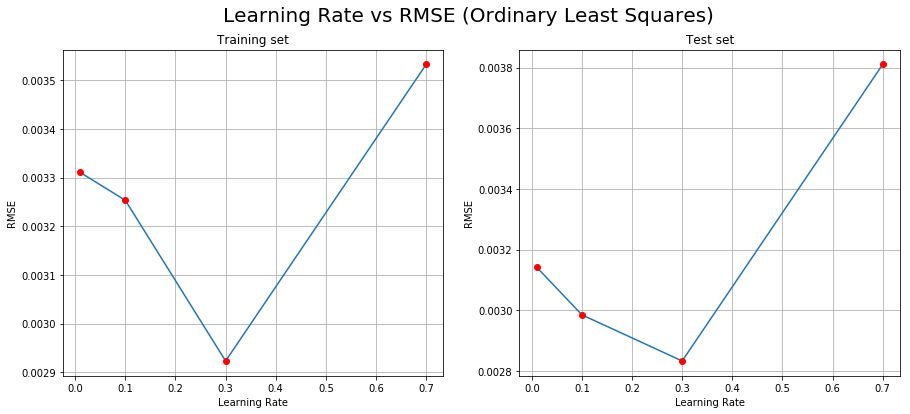

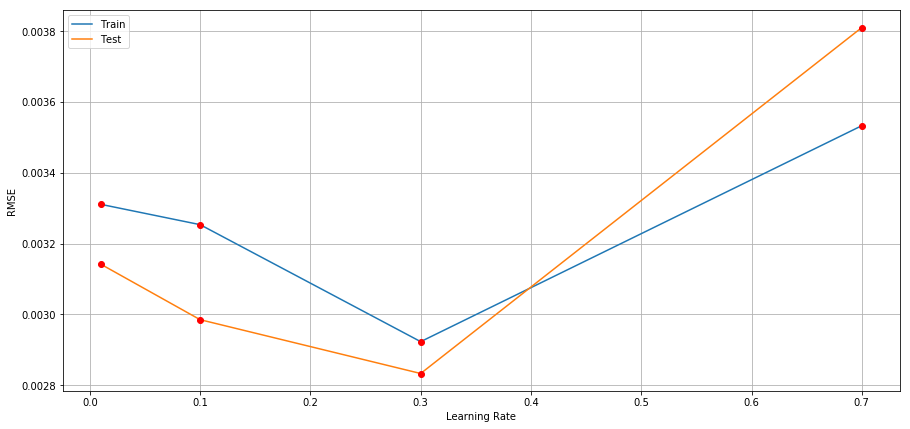

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Learning Rate vs RMSE (Ordinary Least Squares)", fontsize = 20)
ax[0].plot(alpha, RMSE_train_linear)
ax[0].plot(alpha, RMSE_train_linear, "ro")
ax[0].grid()
ax[0].set_xlabel('Learning Rate')
ax[0].set_ylabel('RMSE')
ax[0].set_title("Training set")

ax[1].plot(alpha, RMSE_test_linear)
ax[1].plot(alpha, RMSE_test_linear, "ro")
ax[1].grid()
ax[1].set_xlabel('Learning Rate') 
ax[1].set_ylabel('RMSE')
ax[1].set_title("Test set")
plt.show()
plt.figure(figsize = (15,7))
plt.xlabel('Learning Rate')
plt.ylabel('RMSE')
plt.plot(alpha, RMSE_train_linear,label = "Train")
plt.plot(alpha,RMSE_test_linear,label ="Test")
plt.plot(alpha, RMSE_train_linear, "ro", alpha, RMSE_test_linear,"ro")
plt.grid()
plt.legend()
plt.show()

### Training the model with ridge regression

In [67]:
##Reference:https://stackoverflow.com/questions/27122757/
###sklearn-set-params-takes-exactly-1-argument/29028601
alpha = [0.01,0.1,0.3,0.7]
RMSE_train_ridge = list()
RMSE_test_ridge = list()
for i in alpha:
        param["sgd__penalty"] = 'l2'
        param["sgd__alpha"] = 0.0001
        param["sgd__eta0"] = i
        param["sgd__max_iter"] = 700
        pipe.set_params(**param)
        pipe.fit(X_train,Y_train)
        y_pred_train = pipe.predict(X_train)
        y_pred_test = pipe.predict(X_test)
        RMSE_train_ridge.append(np.sqrt(mean_squared_error(Y_train,y_pred_train)))
        RMSE_test_ridge.append(np.sqrt(mean_squared_error(Y_test,y_pred_test)))
       

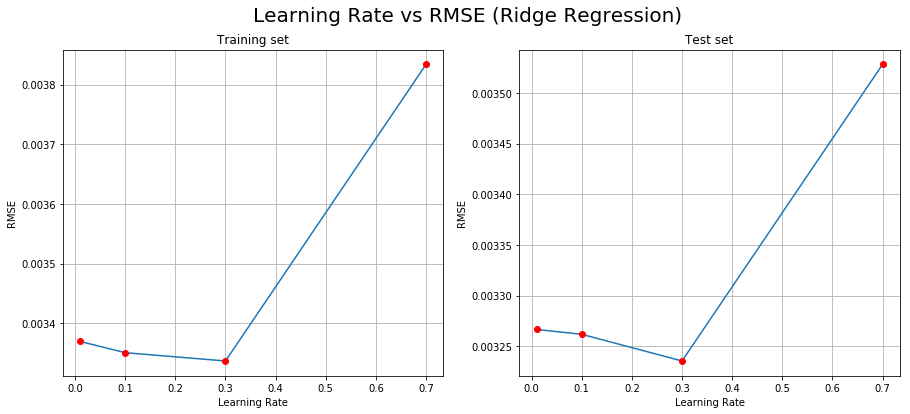

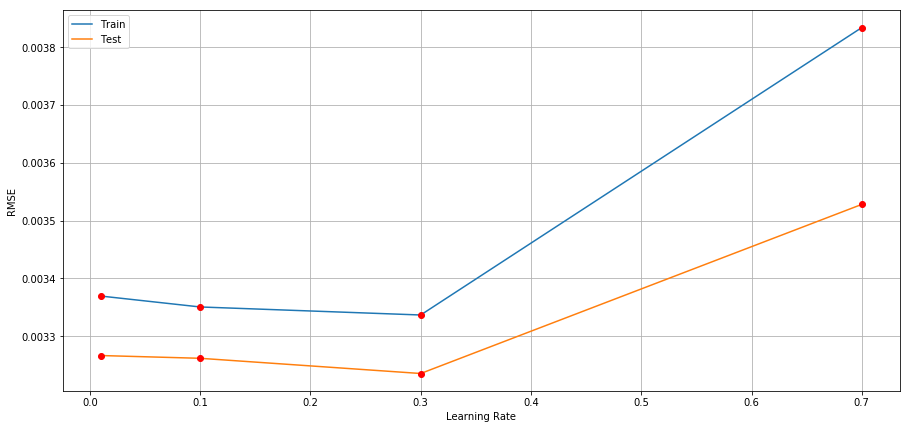

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Learning Rate vs RMSE (Ridge Regression)", fontsize = 20)
ax[0].plot(alpha, RMSE_train_ridge)
ax[0].plot(alpha, RMSE_train_ridge, "ro")
ax[0].grid()
ax[0].set_xlabel('Learning Rate')
ax[0].set_ylabel('RMSE')
ax[0].set_title("Training set")

ax[1].plot(alpha, RMSE_test_ridge)
ax[1].plot(alpha, RMSE_test_ridge, "ro")
ax[1].grid()
ax[1].set_xlabel('Learning Rate') 
ax[1].set_ylabel('RMSE')
ax[1].set_title("Test set")
plt.show()


plt.figure(figsize = (15,7))
plt.xlabel('Learning Rate')
plt.ylabel('RMSE')
plt.plot(alpha, RMSE_train_ridge,label = "Train")
plt.plot(alpha,RMSE_test_ridge,label ="Test")
plt.plot(alpha, RMSE_train_ridge, "ro", alpha, RMSE_test_ridge,"ro")
plt.grid()
plt.legend()
plt.show()

### Training model with LASSO Regression

In [79]:
RMSE_train_lasso = list()
RMSE_test_lasso = list()
alpha = [0.01,0.1,0.3,0.7]
for i in alpha:
        param["sgd__penalty"] = 'l1'
        param["sgd__alpha"] = 0.0001
        param["sgd__eta0"] = i
        param["sgd__max_iter"] = 500
        pipe.set_params(**param)
        pipe.fit(X_train,Y_train)
        y_pred_train = pipe.predict(X_train)
        y_pred_test = pipe.predict(X_test)
        RMSE_train_lasso.append(np.sqrt(mean_squared_error(Y_train,y_pred_train)))
        RMSE_test_lasso.append(np.sqrt(mean_squared_error(Y_test,y_pred_test)))

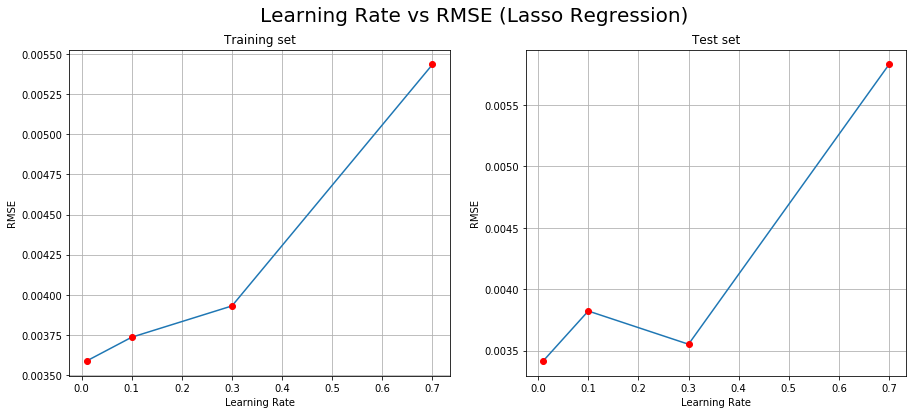

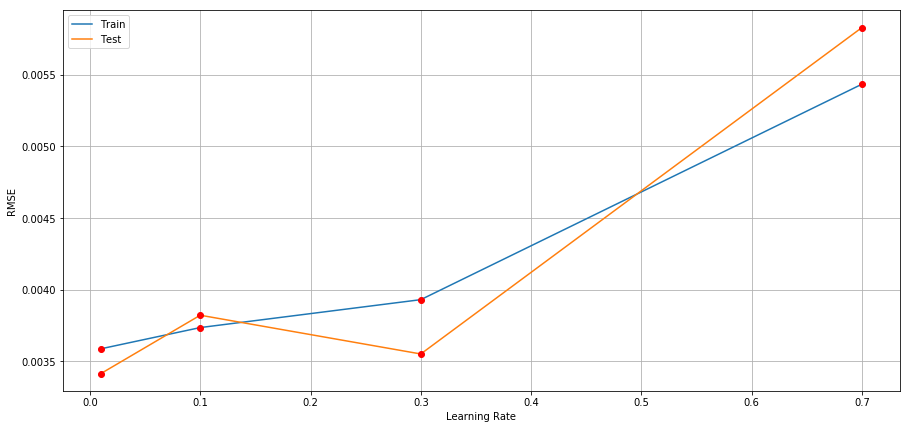

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Learning Rate vs RMSE (Lasso Regression)", fontsize = 20)
ax[0].plot(alpha, RMSE_train_lasso)
ax[0].plot(alpha, RMSE_train_lasso, "ro")
ax[0].grid()
ax[0].set_xlabel('Learning Rate')
ax[0].set_ylabel('RMSE')
ax[0].set_title("Training set")

ax[1].plot(alpha, RMSE_test_lasso)
ax[1].plot(alpha, RMSE_test_lasso, "ro")
ax[1].grid()
ax[1].set_xlabel('Learning Rate') 
ax[1].set_ylabel('RMSE')
ax[1].set_title("Test set")
plt.show()
plt.figure(figsize = (15,7))
plt.xlabel('Learning Rate')
plt.ylabel('RMSE')
plt.plot(alpha, RMSE_train_lasso,label = "Train")
plt.plot(alpha,RMSE_test_lasso,label ="Test")
plt.plot(alpha, RMSE_train_lasso, "ro", alpha, RMSE_test_lasso,"ro")
plt.grid()
plt.legend()
plt.show()


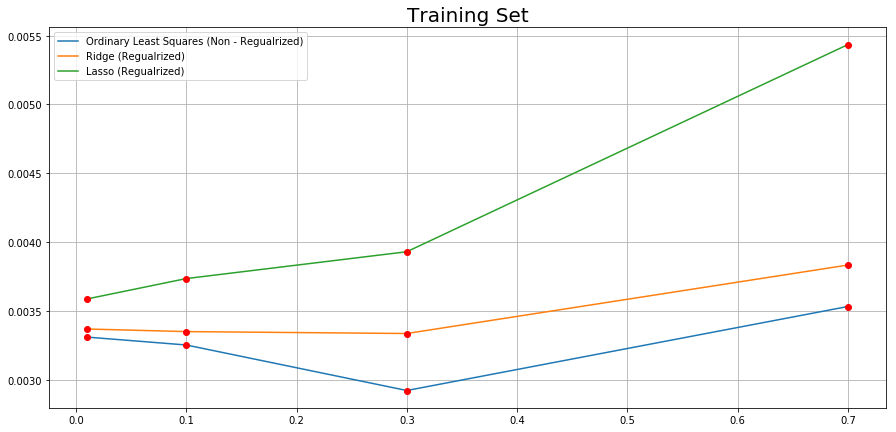

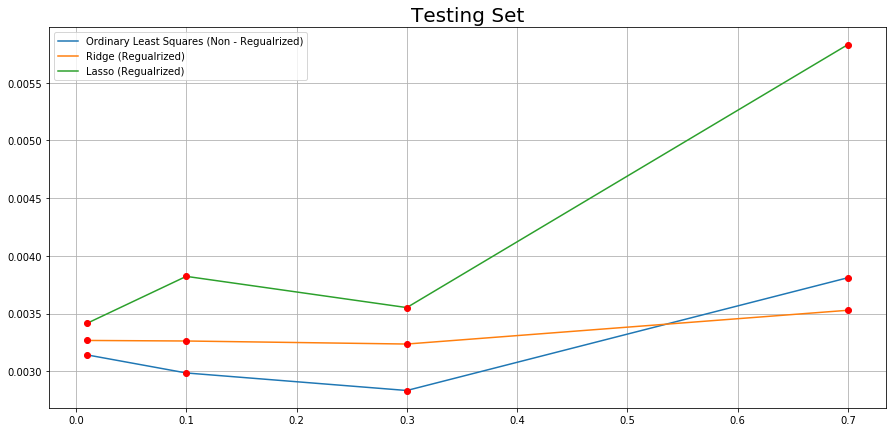

In [82]:
plt.figure(figsize = (15,7))
plt.title("Training Set",fontsize=20)
plt.plot(alpha, RMSE_train_linear,label = "Ordinary Least Squares (Non - Regualrized)")
plt.plot(alpha, RMSE_train_linear,"ro")
plt.plot(alpha, RMSE_train_ridge,label = "Ridge (Regualrized)")
plt.plot(alpha, RMSE_train_ridge, "ro")
plt.plot(alpha, RMSE_train_lasso,label="Lasso (Regualrized)")
plt.plot(alpha, RMSE_train_lasso,"ro")
plt.grid()
plt.legend()
plt.show()
plt.figure(figsize = (15,7))
plt.title("Testing Set",fontsize=20)
plt.plot(alpha,RMSE_test_linear,label = "Ordinary Least Squares (Non - Regualrized)")
plt.plot(alpha, RMSE_test_linear,"ro")
plt.plot(alpha,RMSE_test_ridge, label = "Ridge (Regualrized)")
plt.plot(alpha, RMSE_test_ridge,"ro")
plt.plot(alpha,RMSE_test_lasso,label="Lasso (Regualrized)")
plt.plot(alpha, RMSE_test_lasso,"ro")
plt.legend()
plt.grid()
plt.show()

### Grid Parameters

In [282]:
gridparameters= [{"sgd__learning_rate" : ["constant"],"sgd__eta0" :[0.01,0.1,0.3,0.7],"sgd__penalty" : [None]},
    {"sgd__learning_rate":["constant"],"sgd__penalty":["l2"],"sgd__alpha":[0.1,0.0001,0.001],"sgd__eta0":[0.01,0.1,0.3,0.7]},
    {"sgd__learning_rate":["constant"],"sgd__penalty":["l1"],"sgd__alpha":[0.1,0.0001,0.001],"sgd__eta0":[0.01,0.1,0.3,0.7]}]

###  Grid Search for tuning hyperperameters using Ordinary Least Squares method

In [336]:
gridlinreg= GridSearchCV(pipe,  param_grid = gridparameters[0], cv = 4, n_jobs = 2) ##Refit is always True
gridlinreg.fit(X_train, Y_train)


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('sgd', SGDRegressor(alpha=0.001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.1, fit_intercept=True, l1_ratio=0.15,
       learning_rate='constant', loss='squared_loss', max_iter=700,
       n_iter=None, n_iter_no_change=5, penalty='l1', power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'sgd__eta0': [0.01, 0.1, 0.3, 0.7], 'sgd__learning_rate': ['constant'], 'sgd__penalty': [None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Results:

mean_test_score : [ 0.0456405   0.19792477  0.26148466 -0.2528563 ]
rank_test_score : [3 2 1 4]
split1_train_score : [ 0.13127694  0.24401041  0.33884247 -0.05995475]
std_fit_time : [0.01144841 0.02814929 0.01353072 0.01351795]
split0_test_score : [-0.01285899  0.08748123  0.09828425  0.10032937]
mean_train_score : [ 0.12323913  0.21696385  0.30765503 -0.14375937]
std_test_score : [0.06879347 0.07175803 0.10075136 0.34159381]
params : [{'sgd__eta0': 0.01, 'sgd__learning_rate': 'constant', 'sgd__penalty': None}, {'sgd__eta0': 0.1, 'sgd__learning_rate': 'constant', 'sgd__penalty': None}, {'sgd__eta0': 0.3, 'sgd__learning_rate': 'constant', 'sgd__penalty': None}, {'sgd__eta0': 0.7, 'sgd__learning_rate': 'constant', 'sgd__penalty': None}]
std_score_time : [0.00173254 0.         0.00676624 0.00676954]
std_train_score : [0.01045482 0.04045446 0.02915582 0.36696036]
split0_train_score : [0.13576074 0.25131512 0.31104016 0.33482876]
param_sgd__learning_rate : ['constant' 'constant' '

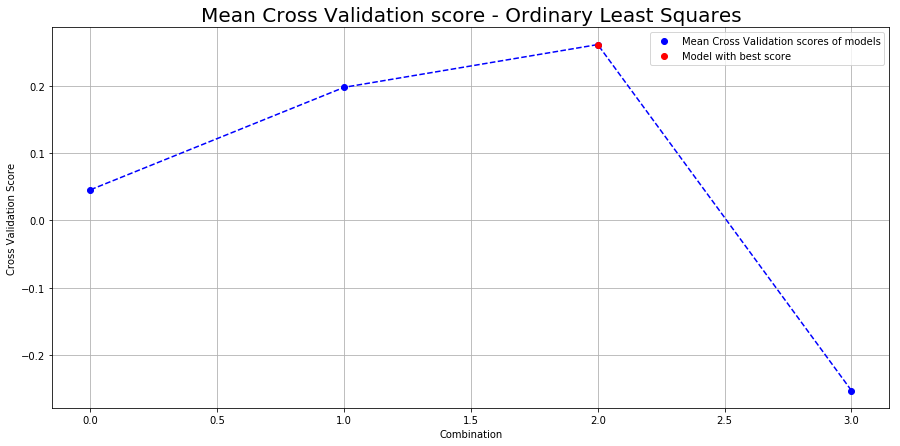

In [337]:
print("Results:\n")
for i in gridlinreg.cv_results_:
    print(i,":",gridlinreg.cv_results_[i])
scores = list(gridlinreg.cv_results_["mean_test_score"])
bestscore = gridlinreg.best_score_
print("\n\n*******************************************************************************************************************************")
print("\n\nBest model after tuning the hyper parameters using Grid Search: \n" + str(gridlinreg.best_params_) + "\n")
print("\nBest score: " + str(bestscore))
print("\nNumber of Folds: " + str(gridlinreg.n_splits_))
plt.figure(figsize = (15, 7))
plt.title("Mean Cross Validation score - Ordinary Least Squares",fontsize = 20)
plt.plot(scores,'b--')
plt.plot(scores, "bo", label = "Mean Cross Validation scores of models")
plt.plot(scores.index(bestscore),bestscore, "ro",label = "Model with best score")
plt.xlabel('Combination')
plt.ylabel('Cross Validation Score')
plt.legend()
plt.grid()
plt.show()

###  Grid Search for tuning hyperperameters using Ridge regression method

In [338]:
gridridreg= GridSearchCV(pipe,  param_grid = gridparameters[1], cv = 4, n_jobs = 2) ##Refit is always True
gridridreg.fit(X_train, Y_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('sgd', SGDRegressor(alpha=0.001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.1, fit_intercept=True, l1_ratio=0.15,
       learning_rate='constant', loss='squared_loss', max_iter=700,
       n_iter=None, n_iter_no_change=5, penalty='l1', power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'sgd__eta0': [0.01, 0.1, 0.3, 0.7], 'sgd__learning_rate': ['constant'], 'sgd__penalty': ['l2'], 'sgd__alpha': [0.1, 0.0001, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Results:


 rank_test_score : [ 6 11  8 12  1  4  2  7  3  5  9 10]

 std_train_score : [0.00575877 0.08168936 0.09027264 0.5601989  0.00982469 0.0474237
 0.03099    0.14111969 0.00275688 0.05872465 0.11578679 0.2190932 ]

 split1_train_score : [-0.00748801 -0.17516151 -0.18851941 -0.19472431  0.11485024  0.11372189
  0.14361932  0.09376448  0.03755298  0.00410718 -0.18749633 -0.39217   ]

 param_sgd__learning_rate : ['constant' 'constant' 'constant' 'constant' 'constant' 'constant'
 'constant' 'constant' 'constant' 'constant' 'constant' 'constant']

 mean_fit_time : [0.19396579 0.16115004 0.1249994  0.15111613 0.19801235 0.15509337
 0.2036404  0.14101702 0.15792185 0.14249957 0.15827239 0.13956088]

 mean_score_time : [0.0020026  0.         0.         0.00100094 0.00200725 0.0049051
 0.00490868 0.00200635 0.00494158 0.00099909 0.00782734 0.00884533]

 split2_train_score : [-0.01582306 -0.03659344 -0.20615762 -1.35111966  0.09192048  0.01746801
  0.06652366  0.11407233  0.03384064  0.0

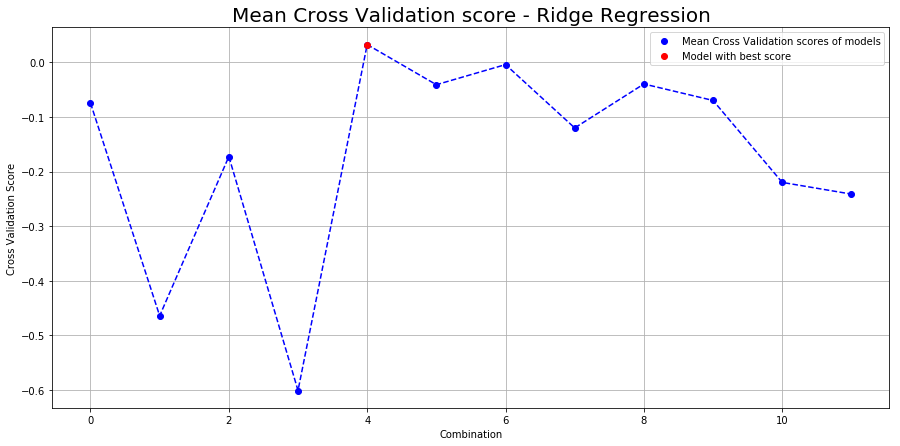

In [339]:
print("Results:\n")
for i in gridridreg.cv_results_:
    if i != 'params':
        print("\n",i,":",gridridreg.cv_results_[i])
scores = list(gridridreg.cv_results_["mean_test_score"])
bestscore = gridridreg.best_score_
print("\n\n*******************************************************************************************************************************")
print("\n\nBest model after tuning the hyper parameters using Grid Search: \n" + str(gridlinreg.best_params_) + "\n")
print("\nBest score: " + str(bestscore))
print("\nNumber of Folds: " + str(gridridreg.n_splits_))
plt.figure(figsize = (15, 7))
plt.title("Mean Cross Validation score - Ridge Regression",fontsize = 20)
plt.plot(scores,'b--')
plt.plot(scores, "bo", label = "Mean Cross Validation scores of models")
plt.plot(scores.index(bestscore),bestscore, "ro",label = "Model with best score")
plt.xlabel('Combination')
plt.ylabel('Cross Validation Score')
plt.legend()
plt.grid()
plt.show()

###  Grid Search for tuning hyperperameters using LASSO regression method

In [340]:
gridlasreg= GridSearchCV(pipe,  param_grid = gridparameters[2], cv = 4, n_jobs = 2) ##Refit is always True
gridlasreg.fit(X_train, Y_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('sgd', SGDRegressor(alpha=0.001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.1, fit_intercept=True, l1_ratio=0.15,
       learning_rate='constant', loss='squared_loss', max_iter=700,
       n_iter=None, n_iter_no_change=5, penalty='l1', power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'sgd__eta0': [0.01, 0.1, 0.3, 0.7], 'sgd__learning_rate': ['constant'], 'sgd__penalty': ['l1'], 'sgd__alpha': [0.1, 0.0001, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Results:


 rank_test_score : [ 2  6 10  7  3  5 11  9  1  4  8 12]

 std_train_score : [2.47834282e-03 3.82882710e-02 1.70192292e-01 2.92743940e-01
 3.37222381e-04 6.06818104e-02 1.61446522e-01 1.87022345e-01
 1.99171939e-03 1.91123304e-02 1.60858655e-01 4.38689518e-01]

 split1_train_score : [-6.58074439e-03 -1.92384520e-03 -2.27148050e-02 -9.25907685e-01
 -1.61316287e-04 -1.55009575e-01 -3.98985159e-01 -2.92923987e-01
 -7.71316986e-03 -4.51783775e-02 -7.26013727e-04 -9.72551420e-01]

 param_sgd__learning_rate : ['constant' 'constant' 'constant' 'constant' 'constant' 'constant'
 'constant' 'constant' 'constant' 'constant' 'constant' 'constant']

 mean_fit_time : [0.26845539 0.22605109 0.20392662 0.20034075 0.18750542 0.2070328
 0.22722912 0.23374259 0.32158136 0.28528875 0.29972535 0.25709283]

 mean_score_time : [0.         0.         0.00299656 0.         0.00390589 0.01171911
 0.00390768 0.00100267 0.00298715 0.00207967 0.00299972 0.00390303]

 split2_train_score : [-1.79846364e-0

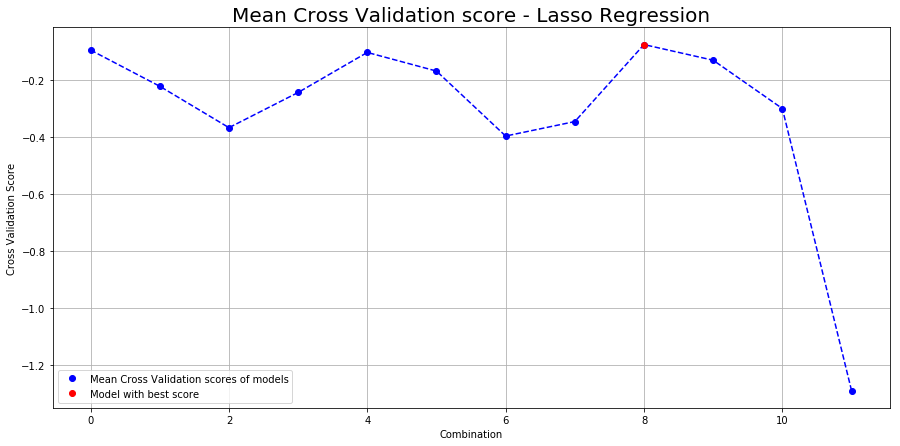

In [341]:
print("Results:\n")
for i in gridlasreg.cv_results_:
    if i != 'params':
        print("\n",i,":",gridlasreg.cv_results_[i])
scores = list(gridlasreg.cv_results_["mean_test_score"])
bestscore = gridlasreg.best_score_
print("\n\n*******************************************************************************************************************************")
print("\n\nBest model after tuning the hyper parameters using Grid Search: \n" + str(gridlinreg.best_params_) + "\n")
print("\nBest score: " + str(bestscore))
print("\nNumber of Folds: " + str(gridlasreg.n_splits_))
plt.figure(figsize = (15, 7))
plt.title("Mean Cross Validation score - Lasso Regression",fontsize = 20)
plt.plot(scores,'b--')
plt.plot(scores, "bo", label = "Mean Cross Validation scores of models")
plt.plot(scores.index(bestscore),bestscore, "ro",label = "Model with best score")
plt.xlabel('Combination')
plt.ylabel('Cross Validation Score')
plt.legend()
plt.grid()
plt.show()

### Evaluate each model with optimal parameters

In [357]:
cv_linreg = cross_val_score(pipe.set_params(**gridlinreg.best_params_),X_train,Y_train,cv=4)
cv_ridreg = cross_val_score(pipe.set_params(**gridridreg.best_params_),X_train,Y_train,cv=4)
cv_lasreg = cross_val_score(pipe.set_params(**gridlasreg.best_params_),X_train,Y_train,cv=4)

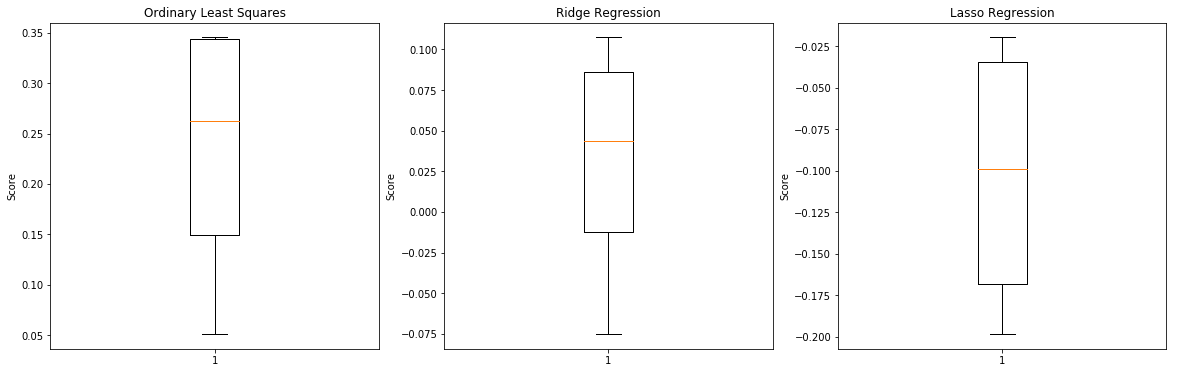

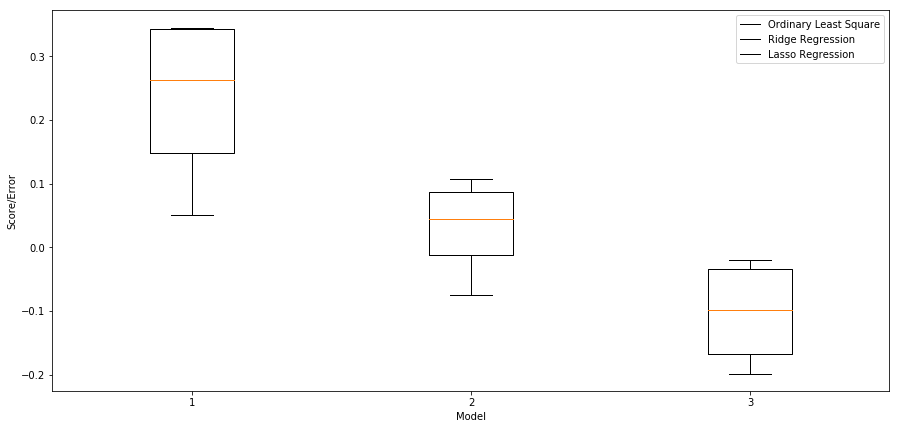

In [374]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ax[0].boxplot(cv_linreg)
ax[0].set_title("Ordinary Least Squares")
ax[0].set_ylabel("Score")
ax[1].boxplot(cv_ridreg)
ax[1].set_title("Ridge Regression")
ax[1].set_ylabel("Score")
ax[2].boxplot(cv_lasreg)
ax[2].set_title("Lasso Regression")
ax[2].set_ylabel("Score")
plt.show()
plt.figure(figsize = (15,7))
a = plt.boxplot([cv_linreg,cv_ridreg,cv_lasreg])
plt.legend([a["boxes"][0], a["boxes"][1],a["boxes"][1]], ["Ordinary Least Square","Ridge Regression","Lasso Regression"], loc='upper right')
plt.xlabel("Model")
plt.ylabel("Score/Error")
plt.show()